<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Work/blob/main/06_25_22_Base_GloVe300D_Conv1d_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# First we import the required libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf

from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = Path("/content/drive/MyDrive/")
assert base_dir.exists()

Mounted at /content/drive


Fake 0
Real 1

In [3]:
df_fake = pd.read_csv(base_dir/'politifact_fake.csv')
df_real = pd.read_csv(base_dir/'politifact_real.csv')
df_fake['labelML']=0
df_real['labelML']=1

In [4]:
news= df_fake.append(df_real)
news.reset_index(drop=True, inplace=True)

In [5]:
# news_dummies = pd.get_dummies(news.labelML)
# news = pd.concat([news, news_dummies], axis=1)

In [6]:
news.head()

,id,news_url,title,tweet_ids,labelML
0,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,937349434668498944\t937379378006282240\t937380...,0
1,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,972666281441878016\t972678396575559680\t972827...,0
2,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,929405740732870656\t929439450400264192\t929439...,0
3,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,886941526458347521\t887011300278194176\t887023...,0
4,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,915205698212040704\t915242076681506816\t915249...,0


In [7]:
news.tail()

,id,news_url,title,tweet_ids,labelML
1051,politifact14731,https://www.flake.senate.gov/public/index.cfm/...,Flake: “Religious tests should have no place i...,NaN,1
1052,politifact329,https://web.archive.org/web/20080131000131/htt...,Change We Can Believe In,634287923135909888\t946743411100536832\t946816...,1
1053,politifact1576,http://www.youtube.com/watch?v=4O8CxZ1OD58,deputy director of national health statistics ...,NaN,1
1054,politifact4720,http://www.youtube.com/watch?v=EhyMplwY6HY,Romneys ProLife Conversion Myth or Reality Jun...,188871706637647874,1
1055,politifact52,https://web.archive.org/web/20071102131244/htt...,Interest Group Ratings,1002208963239337984\t1024651239697666048,1


In [8]:
news = news.drop(['tweet_ids', 'news_url','id'], axis=1)

assert not news.isna().any().any()
news.count()

title      1056
labelML    1056
dtype: int64

In [9]:
news.dtypes

title      object
labelML     int64
dtype: object

In [10]:
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
news['title']= news['title'].apply(denoise_text)

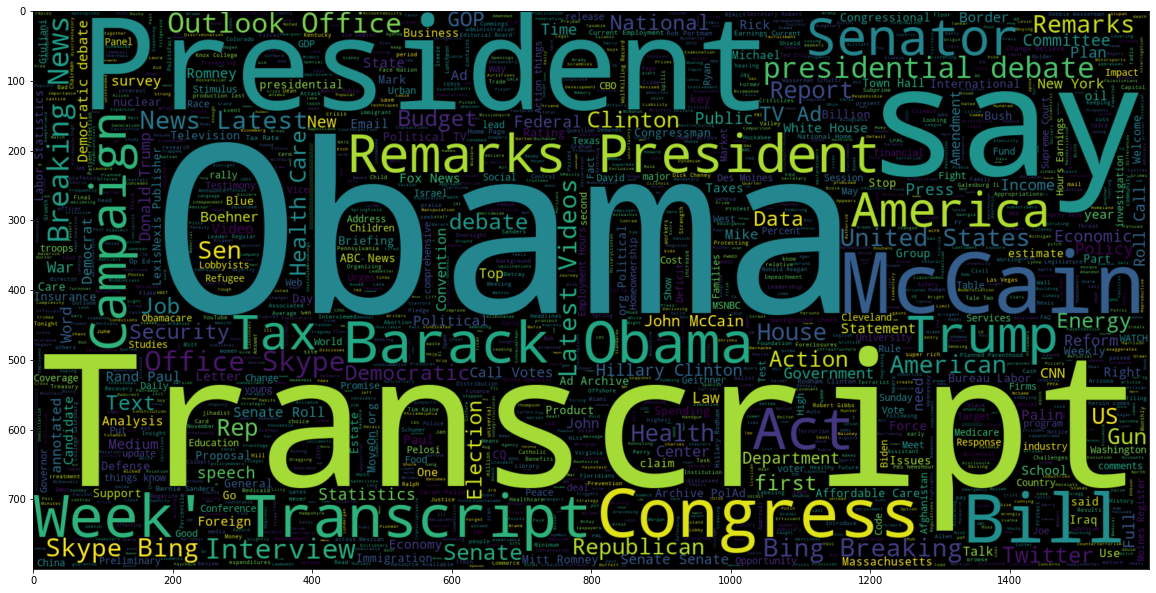

In [12]:
#WORDCLOUD FOR REAL TEXT (LABEL - 1)
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 1].title))
plt.imshow(wc , interpolation = 'bilinear');

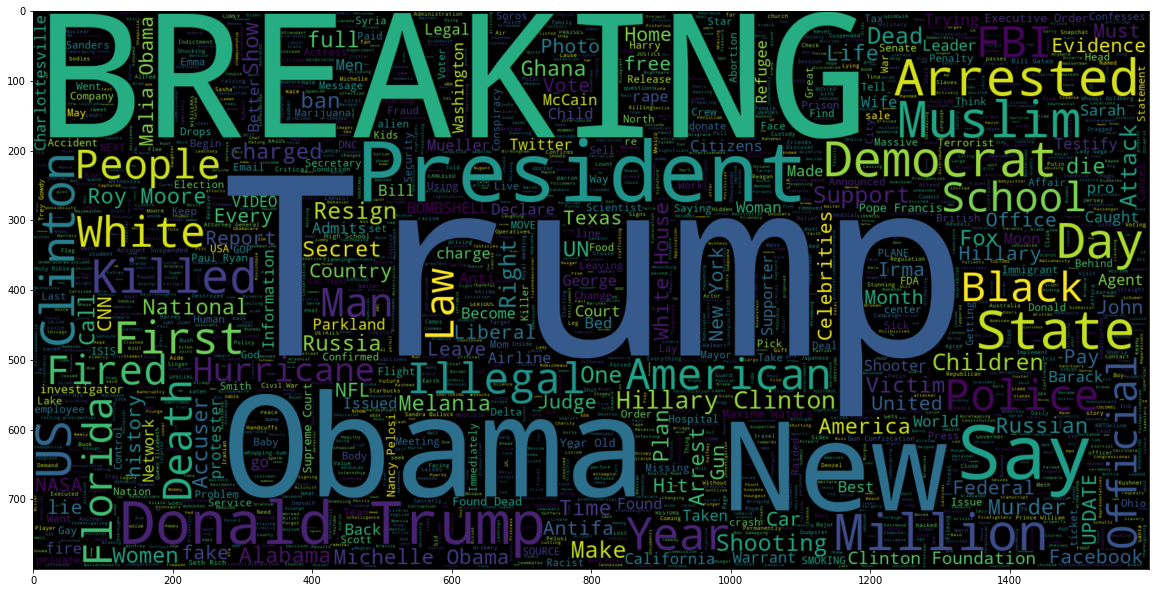

In [13]:
#WORDCLOUD FOR Fake TEXT (LABEL - 0)
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news[news.labelML == 0].title))
plt.imshow(wc , interpolation = 'bilinear');

In [14]:
#Splitting the data into 2 parts - training and testing data
X_train, X_test,y_train,y_test = train_test_split(news.title,news.labelML,test_size=0.3,random_state=42)
# max_features = 3281
# maxlen = 3281

In [15]:
#Tokenizing Text -> Repsesenting each word by a number
tokenizer = text.Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)

# x_train = sequence.pad_sequences()
#maxlen should be the longest sequence that we have, padding comes upto that length. 
#mask_0=True add to the embedding layer. so that the 0 mask is ignored. 
#after embedding add another layer that does the mean .. tf.keras.layers.Average. to find the average. conf2d and pooling not needed. 

In [16]:
max_len = max(map(len, tokenized_train))

In [17]:
max(tokenizer.word_index.values())

2776

In [18]:
X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [19]:
!wget https://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip glove.6B.300d.txt

--2022-06-25 08:14:19--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-06-25 08:14:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.97MB/s    in 2m 40s  

2022-06-25 08:16:59 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.300d.txt       


In [20]:
#Glove
EMBEDDING_FILE = './glove.6B.300d.txt' #'/content/drive/MyDrive/glove.6B.50d.txt'

In [21]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [22]:
len(embeddings_index['question'])

300

from tensorflow.python.ops.array_ops import zeros
from pandas.core.arrays.sparse import array
1. form an empty list, holds embedding confusion_matrix
.. add empty array to array of zeros- padding token
2. iterate from smaller toekn no to biggest token no 0....n, token[0]=empty array
3. for each no, find what is the word and look it up in the all_embs, then append to embedding emb matrix


In [23]:
emb_matrix=list()
emb_matrix.append(np.zeros(300,dtype=np.float32))
for i in range(1,max(tokenizer.word_index.values())+1):
  word = tokenizer.index_word[i]
  if word not in embeddings_index:
    emb_matrix.append(np.zeros(300,dtype=np.float32))
  else: 
    emb_matrix.append(embeddings_index[word]) 

In [24]:
emb_matrix[:3]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [25]:
emb_matrix = np.stack(emb_matrix, axis=0)
emb_matrix.shape

(2777, 300)

In [26]:
batch_size = 256
epochs = 200
embed_size = 50
# tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)

In [29]:
#with Gabriel
#Defining Neural Network
# model = Sequential()
#Non-trainable embeddidng layer
# model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
# model.add(LSTM(units=128 , return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=64))
# model.add(Dropout(0.1))
# model.add(Dense(units = 32 , activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# emb_matrix2 = np.array(emb_matrix)
#Hybrid Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(emb_matrix.shape[0], output_dim=emb_matrix.shape[1], weights=[emb_matrix],trainable=False, mask_zero=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(256, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.4),  
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [30]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         833100    
                                                                 
 dropout_7 (Dropout)         (None, None, 300)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 256)         384256    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 256)        0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, None, 20)          22160     
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                      

In [32]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test, y_test), epochs=epochs)

Epoch 1/200
3/3 [==============================] - 17s 504ms/step - loss: 0.6888 - accuracy: 0.5765 - val_loss: 0.6827 - val_accuracy: 0.5647
Epoch 2/200
3/3 [==============================] - 0s 22ms/step - loss: 0.6678 - accuracy: 0.6522 - val_loss: 0.6597 - val_accuracy: 0.5994
Epoch 3/200
3/3 [==============================] - 0s 20ms/step - loss: 0.6268 - accuracy: 0.7321 - val_loss: 0.6165 - val_accuracy: 0.7003
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 0.5585 - accuracy: 0.7740 - val_loss: 0.5647 - val_accuracy: 0.7287
Epoch 5/200
3/3 [==============================] - 0s 20ms/step - loss: 0.4789 - accuracy: 0.8349 - val_loss: 0.5117 - val_accuracy: 0.7508
Epoch 6/200
3/3 [==============================] - 0s 20ms/step - loss: 0.3934 - accuracy: 0.8647 - val_loss: 0.4829 - val_accuracy: 0.7571
Epoch 7/200
3/3 [==============================] - 0s 21ms/step - loss: 0.3264 - accuracy: 0.8850 - val_loss: 0.5003 - val_accuracy: 0.7539
Epoch 8/200
3/3 [=

In [33]:
model.evaluate(X_train,y_train)
model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 8ms/step - loss: 2.0371 - accuracy: 0.7855


[2.037102699279785, 0.7854889631271362]

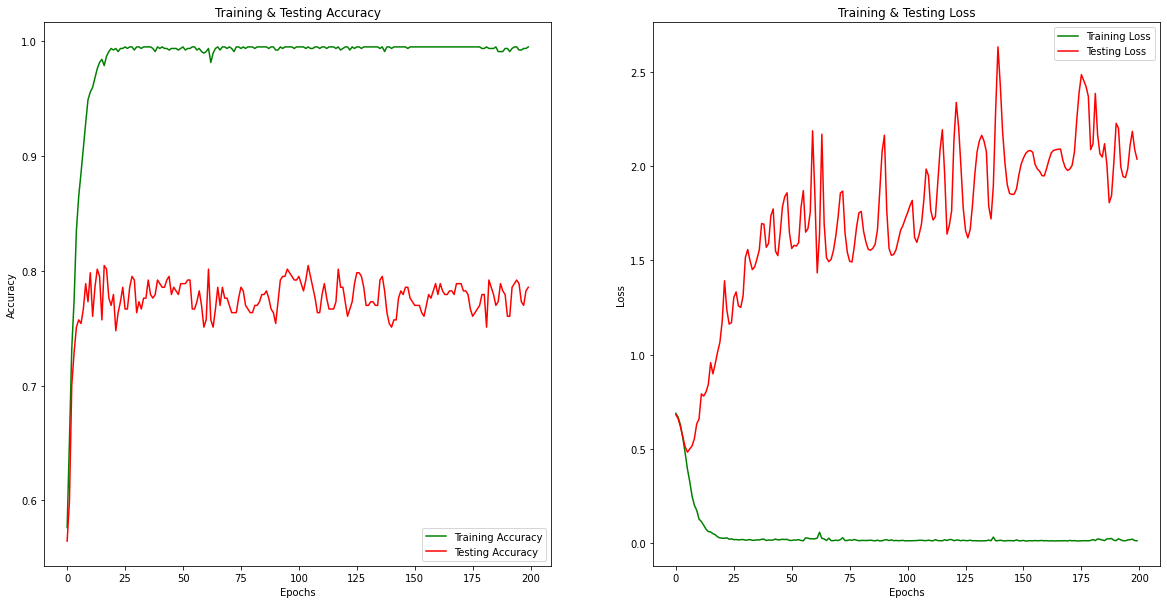

In [34]:
epoch_list = [i for i in range(0,epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epoch_list , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epoch_list , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch_list , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epoch_list , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [35]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Final layer has sigmoid activation. If pred < 0.5 class is 0 (Fake), else 1 (Real)

In [36]:
pred_train_classes = (pred_train > 0.5).astype(int)
pred_test_classes = (pred_test > 0.5).astype(int)

In [37]:
(pred_train_classes.squeeze() == y_train).mean(), (pred_test_classes.squeeze() == y_test).mean()

(0.9945872801082544, 0.7854889589905363)

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

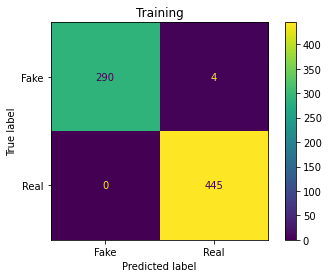

In [39]:
cmdisp = ConfusionMatrixDisplay.from_predictions(y_train, pred_train_classes, display_labels=["Fake", "Real"])
cmdisp.ax_.set_title("Training")
plt.show()

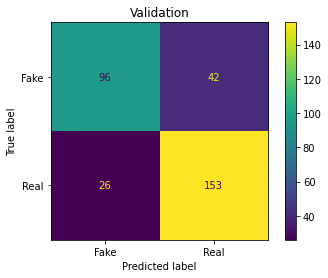

In [40]:
cmdisp = ConfusionMatrixDisplay.from_predictions(y_test, pred_test_classes, display_labels=["Fake", "Real"])
cmdisp.ax_.set_title("Validation")
plt.show()

In [41]:
from collections import Counter


print(Counter(y_test).keys()) # equals to list(set(words))
print(Counter(y_test).values())

dict_keys([0, 1])
dict_values([138, 179])


In [42]:
sentence = ["All the universities and schools remain closed for two months due to the corona virus outbreak in the country."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = sequence.pad_sequences(sequences, maxlen=max_len)
model_decision = model.predict(padded)
print(model_decision)

[[6.2197594e-13]]


In [43]:
sentence1 = ["leeee keen to nooo where leaves"]
sequences1 = tokenizer.texts_to_sequences(sentence)
padded1 = sequence.pad_sequences(sequences1, maxlen=max_len)
model_decision1 = model.predict(padded1)
print(model_decision1)

[[6.2197594e-13]]
